<a href="https://colab.research.google.com/github/KRISHNPRIY2820/iot_lab_1/blob/main/ft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd

# Load raw data
df = pd.read_csv("csv_data_4.csv")

# Percentile thresholds
hum_q20 = df['humidity'].quantile(0.2)
hum_q80 = df['humidity'].quantile(0.8)
gas_q80 = df['gas'].quantile(0.8)
temp_q80 = df['temperature'].quantile(0.8)
temp_q20 = df['temperature'].quantile(0.2)

# def assign_label(row):
#     if row['gas'] >= gas_q80:
#         return 'polluted'
#     elif row['humidity'] >= hum_q80:
#         return 'humid'
#     elif row['humidity'] <= hum_q20:
#         return 'dry'
#     elif row['temperature'] >= temp_q80:
#         return 'hot'
#     elif row['temperature'] <= temp_q20:
#         return 'cold'
#     else:
#         return 'comfortable'
def assign_label(row):
    score = {
        "polluted": row["gas"] / gas_q80,
        "humid": row["humidity"] / hum_q80,
        "dry": hum_q20 / max(row["humidity"], 1),
        "hot": row["temperature"] / temp_q80,
        "cold": temp_q20 / max(row["temperature"], 1),
        "comfortable": 1.0
    }
    return max(score, key=score.get)


df['label'] = df.apply(assign_label, axis=1)
df.to_csv("train_labeled.csv", index=False)

print(df['label'].value_counts())


label
comfortable    1462
polluted        654
cold            533
humid           140
dry             105
hot              77
Name: count, dtype: int64


In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models

# Load labeled data
df = pd.read_csv("train_labeled.csv")
def scale_features(X):
    Xs = np.zeros_like(X, dtype=np.float32)

    Xs[:, 0] = X[:, 0] / 50.0           # temperature (0–50°C)
    Xs[:, 1] = X[:, 1] / 100.0          # humidity (0–100%)
    Xs[:, 2] = (X[:, 2] - 1000.0) / 50.0  # pressure centered
    Xs[:, 3] = X[:, 3] / 300.0          # gas (assumed <300)

    return Xs

X_raw = df[['temperature','humidity','pressure','gas']].values
X = scale_features(X_raw)

y = df['label'].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# # Normalization INSIDE model
# normalizer = layers.Normalization()
# normalizer.adapt(X_train)

# MICRO-FRIENDLY MODEL
# model = models.Sequential([
#     layers.Input(shape=(4,)),
#     normalizer,
#     layers.Dense(12, activation='relu'),
#     layers.Dense(len(le.classes_), activation='softmax')
# ])
model = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_enc),
    y=y_enc
)
class_weights = dict(enumerate(class_weights))

# model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)
model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weights
)


model.summary()


Epoch 1/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0375 - loss: 1.7360 - val_accuracy: 0.0294 - val_loss: 1.7996
Epoch 2/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0277 - loss: 1.7837 - val_accuracy: 0.0294 - val_loss: 1.7974
Epoch 3/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0747 - loss: 1.7602 - val_accuracy: 0.0294 - val_loss: 1.7860
Epoch 4/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0444 - loss: 1.7690 - val_accuracy: 0.1134 - val_loss: 1.7843
Epoch 5/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2247 - loss: 1.8001 - val_accuracy: 0.2143 - val_loss: 1.7786
Epoch 6/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1150 - loss: 1.8399 - val_accuracy: 0.2185 - val_loss: 1.7846
Epoch 7/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2563 - loss: 1.7805 - val_accuracy: 0.1975 - val_loss: 1.7822
Epoch 8/60
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2998 - loss: 1.7244 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548 (2.14 KB)

 Trainable params: 182 (728.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 366 (1.43 KB)

In [21]:
def representative_dataset():
    for i in range(200):
        yield [X_train[i:i+1].astype(np.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("climate_micro.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite Micro size:", len(tflite_model))



Saved artifact at '/tmp/tmppgp0vq77'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134068948305872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948307792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134068948311056: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite Micro size: 2808


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [22]:
# ---------- KERAS ACCURACY ----------
y_pred_keras = np.argmax(model.predict(X_test), axis=1)

print("Keras accuracy:",
      accuracy_score(y_test, y_pred_keras))

print("\nClassification report (Keras):")
print(classification_report(
    y_test, y_pred_keras,
    target_names=le.classes_
))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Keras accuracy: 0.5159663865546219

Classification report (Keras):
              precision    recall  f1-score   support

        cold       0.42      0.98      0.58       107
 comfortable       0.97      0.22      0.36       293
         dry       0.08      0.19      0.11        21
         hot       0.05      0.13      0.08        15
       humid       0.00      0.00      0.00        28
    polluted       0.70      1.00      0.82       131

    accuracy                           0.52       595
   macro avg       0.37      0.42      0.33       595
weighted avg       0.71      0.52      0.47       595



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [23]:
# Load labeled dataset
df = pd.read_csv("train_labeled.csv")

X = df[['temperature', 'humidity', 'pressure', 'gas']].values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Class order:", le.classes_)


Class order: ['cold' 'comfortable' 'dry' 'hot' 'humid' 'polluted']


In [24]:
interpreter = tf.lite.Interpreter(model_path="climate_micro.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Quantization params
in_scale, in_zero = input_details[0]['quantization']
out_scale, out_zero = output_details[0]['quantization']

y_pred_tflite = []

for sample in X_test:
    # normalize happens inside model
    sample = sample.astype(np.float32)

    # quantize input
    sample_q = sample / in_scale + in_zero
    sample_q = np.clip(sample_q, -128, 127).astype(np.int8)
    sample_q = np.expand_dims(sample_q, axis=0)

    interpreter.set_tensor(input_details[0]['index'], sample_q)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])[0]
    output = (output.astype(np.float32) - out_zero) * out_scale

    y_pred_tflite.append(np.argmax(output))

# ---------- TFLITE ACCURACY ----------
print("TFLite INT8 accuracy:",
      accuracy_score(y_test, y_pred_tflite))

print("\nClassification report (TFLite):")
print(classification_report(
    y_test, y_pred_tflite,
    target_names=le.classes_
))


TFLite INT8 accuracy: 0.5025210084033613

Classification report (TFLite):
              precision    recall  f1-score   support

        cold       0.43      0.93      0.59       107
 comfortable       0.89      0.23      0.36       293
         dry       0.05      0.14      0.07        21
         hot       0.00      0.00      0.00        15
       humid       0.00      0.00      0.00        28
    polluted       0.63      1.00      0.77       131

    accuracy                           0.50       595
   macro avg       0.33      0.38      0.30       595
weighted avg       0.66      0.50      0.46       595



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

🚀 Starting continuous IoT data analysis...
📥 Received 2001 new rows


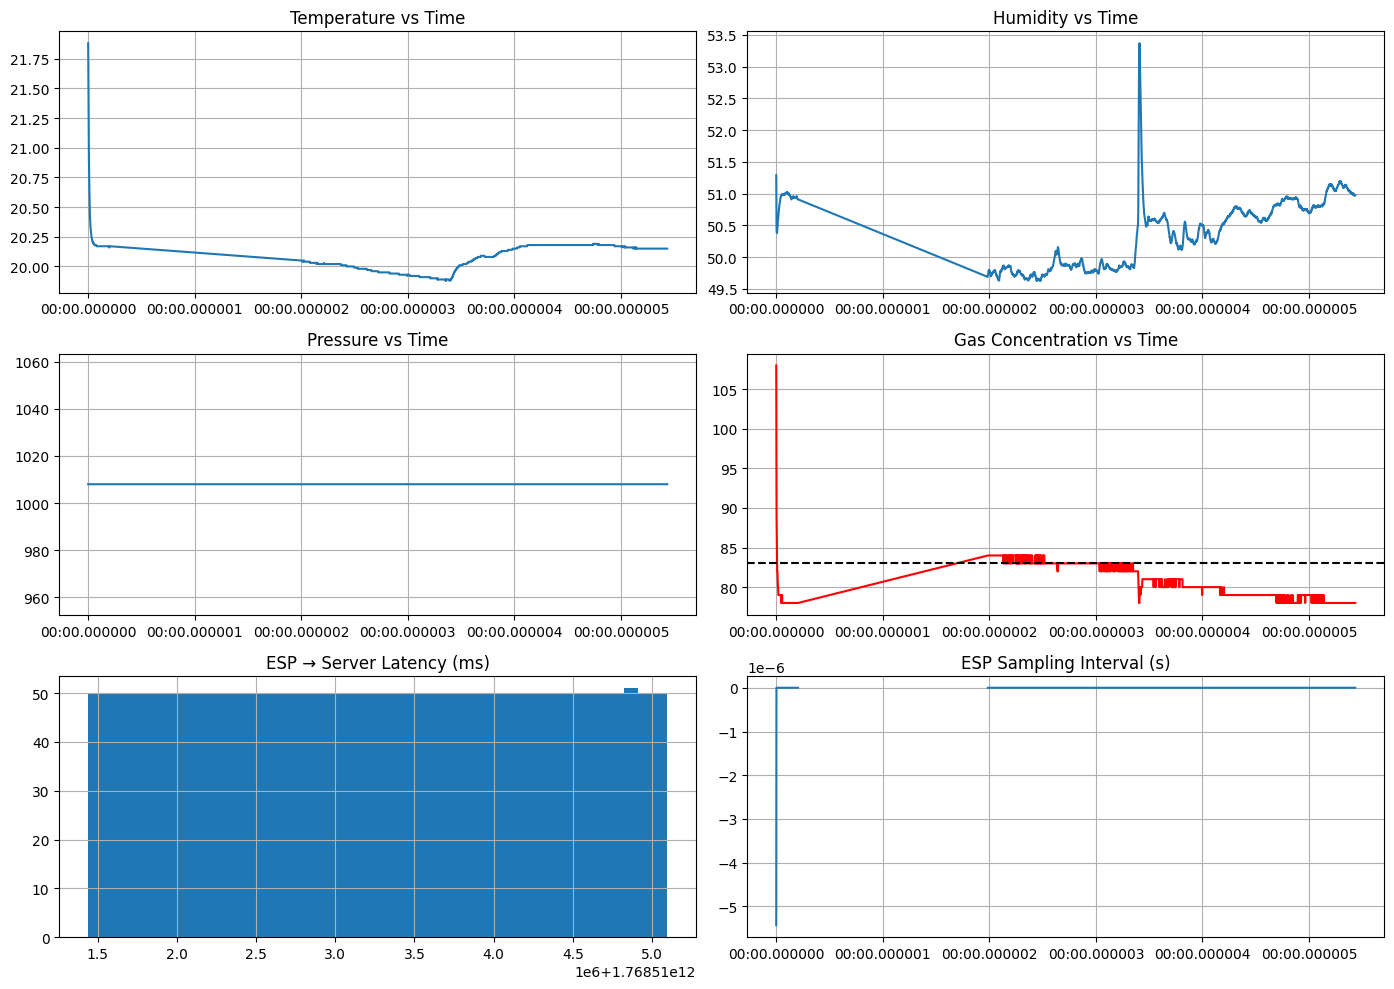

➡ Switching to csv_data_2.csv
📥 Received 456 new rows


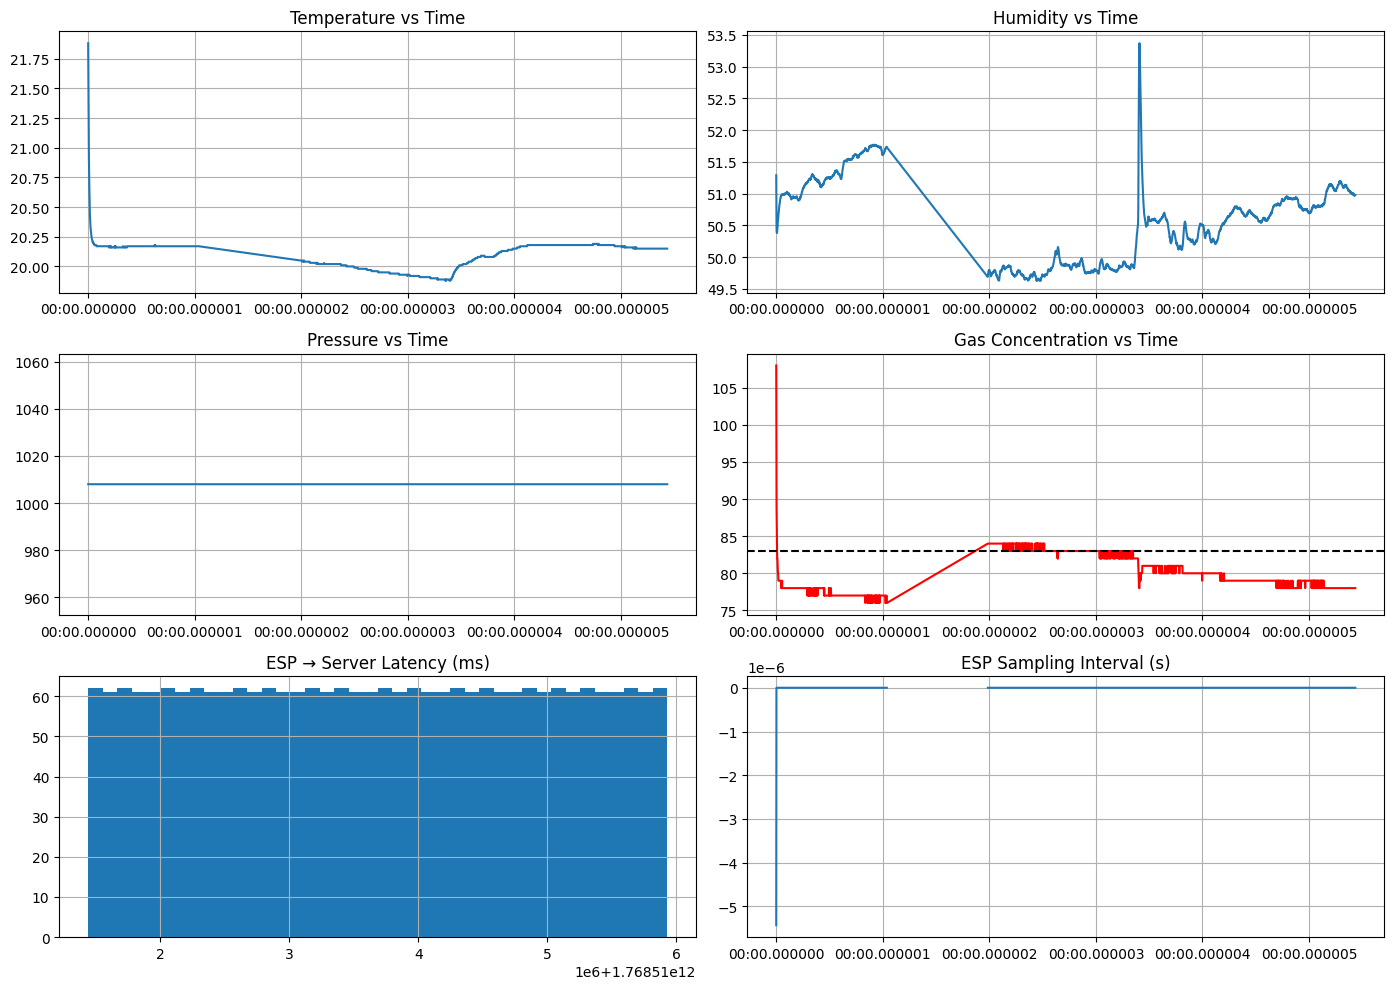

KeyboardInterrupt: 

In [18]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
from io import StringIO

# ---------------- CONFIG ----------------
BASE_URL = "https://azure.abhi.dedyn.io/iot/csv_data_{}.csv"
POLL_INTERVAL = 5          # seconds
ROLLING_ROWS = 5000        # keep last N rows only
START_FILE_INDEX = 1

# ---------------- STATE ----------------
current_file = START_FILE_INDEX
last_row_processed = 0
data_buffer = pd.DataFrame()

# ---------------- FETCH CSV ----------------
def fetch_csv(file_idx):
    url = BASE_URL.format(file_idx)
    try:
        r = requests.get(url, timeout=5)
        if r.status_code != 200:
            return None
        return pd.read_csv(
            StringIO(r.text),
            header=None,
            names=[
                "temperature",
                "humidity",
                "pressure",
                "gas",
                "timestamp_esp",
                "timestamp_server"
            ]
        )
    except Exception as e:
        print("Fetch error:", e)
        return None

# ---------------- PREPROCESS ----------------
def preprocess(df):
    df = df.copy()

    df["timestamp_esp"] = pd.to_datetime(df["timestamp_esp"])
    df["timestamp_server"] = pd.to_datetime(df["timestamp_server"])

    # Latency calculation (ms)
    df["latency_ms"] = (
        df["timestamp_server"] - df["timestamp_esp"]
    ).dt.total_seconds() * 1000

    # ESP sampling interval (sec)
    df["esp_dt"] = df["timestamp_esp"].diff().dt.total_seconds()

    return df.sort_values("timestamp_esp")

# ---------------- PLOTS ----------------
def plot_all(df):
    plt.figure(figsize=(14, 10))

    # Temperature
    plt.subplot(3,2,1)
    plt.plot(df["timestamp_esp"], df["temperature"])
    plt.title("Temperature vs Time")
    plt.grid()

    # Humidity
    plt.subplot(3,2,2)
    plt.plot(df["timestamp_esp"], df["humidity"])
    plt.title("Humidity vs Time")
    plt.grid()

    # Pressure
    plt.subplot(3,2,3)
    plt.plot(df["timestamp_esp"], df["pressure"])
    plt.title("Pressure vs Time")
    plt.grid()

    # Gas
    plt.subplot(3,2,4)
    plt.plot(df["timestamp_esp"], df["gas"], color="red")
    plt.axhline(df["gas"].quantile(0.8), linestyle="--", color="black")
    plt.title("Gas Concentration vs Time")
    plt.grid()

    # Latency
    plt.subplot(3,2,5)
    plt.hist(df["latency_ms"], bins=40)
    plt.title("ESP → Server Latency (ms)")
    plt.grid()

    # Sampling interval
    plt.subplot(3,2,6)
    plt.plot(df["timestamp_esp"], df["esp_dt"])
    plt.title("ESP Sampling Interval (s)")
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN LOOP ----------------
print("🚀 Starting continuous IoT data analysis...")

while True:
    df = fetch_csv(current_file)

    if df is None:
        print("Waiting for csv_data_", current_file)
        time.sleep(POLL_INTERVAL)
        continue

    # Detect file rollover
    if len(df) >= 2001 and last_row_processed >= 2001:
        print(f"➡ Switching to csv_data_{current_file + 1}.csv")
        current_file += 1
        last_row_processed = 0
        continue

    # Extract new rows
    new_rows = df.iloc[last_row_processed:]
    last_row_processed = len(df)

    if len(new_rows) > 0:
        data_buffer = pd.concat([data_buffer, new_rows], ignore_index=True)

        # Keep rolling window
        if len(data_buffer) > ROLLING_ROWS:
            data_buffer = data_buffer.iloc[-ROLLING_ROWS:]

        print(f"📥 Received {len(new_rows)} new rows")

        # Preprocess & plot
        processed = preprocess(data_buffer)
        plot_all(processed)

    time.sleep(POLL_INTERVAL)
